## Домашнее здание №3 / New Product Forecasting

### Фамилия Имя / Группа

----
План выполнения домашнего задания:

1. Подготовка данных
2. Предсказание без категориальных признаков
3. Предсказание с категориальными признаками
4.  Другие модели и генерация дополнительных признаков
5. Отправка результатов в контест на Kaggle

In [1]:
import pandas as pd
import numpy as np
from random import shuffle
from sklearn import tree
from copy import deepcopy
from sklearn.ensemble import BaggingRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import cross_validation
from sklearn.dummy import DummyRegressor
from scipy.optimize import minimize_scalar
%matplotlib inline

## Подготовка данных (1 балл)
 * Изучить признаки
 * Выделить категориальные признаки, которые можно использовать для обучения
 * Выделить датасет только с числовыми признаками
 * Выделить полезные числовые признаки

In [152]:
data = pd.read_csv('./train.csv', sep=';', index_col='ID')
data.shape

(40000, 33)

In [147]:
data.head()

,DEMAND,LOCATION_ID,MODEL_BRAND,MODEL_COST_AVG,MODEL_COUNT_SALES_DAYS,MODEL_DIAG,MODEL_DIAG_TYPE,MODEL_HEIGHT,MODEL_ID,MODEL_MEAN_SALES,...,STORE_FORMAT,STORE_OPEN_DTTM,STORE_PRICE_TYPE,STORE_REGION,STORE_RES_ABC,STORE_RES_SPECTR,STORE_TYPE_A,STORE_TYPE_B,STORE_TYPE_C,STORE_TYPE_SPECTR
ID,,,,,,,,,,,,,,,,,,,,,
0,0.10536,1835543262,ark,5179.7500,NaN,5.5,big,720.0,1682,NaN,...,новый формат,19MAY15:00:00:00,розничная цена (северо-запад-санкт-петербург),северо-запад,B,0.67,0.75,0.25,0.0,3.06
1,0.00010,1972241965,samsung,22015.3300,NaN,5.2,big,1920.0,34706,NaN,...,новый формат,20JAN16:00:00:00,розничная цена (северо-запад-днс1),северо-запад,C,0.48,0.00,1.00,0.0,2.51
2,0.00010,2027986985,samsung,15592.5900,NaN,5.0,big,1280.0,2753,NaN,...,новый формат,27APR16:00:00:00,розничная цена (дальний восток-якутск),дальний восток,A,0.64,1.00,0.00,0.0,2.72
3,0.00010,28432,alcatel,540.9533,29.0,1.8,small,128.0,1593,7.533,...,стандарт,21OCT09:00:00:00,розничная цена (северо-запад-боровичи),северо-запад,B,0.65,0.50,0.25,0.0,2.04
4,0.00010,28547,мтс,444.7300,30.0,4.0,medium,480.0,80644,16.830,...,стандарт,20MAY09:00:00:00,розничная цена (северо-запад-санкт-петербург),северо-запад,A,0.83,0.75,0.25,0.0,2.37


### Категориальные признаки
 * Какие категориальные признаки следует использовать в первую очередь? 
 * Есть ли категориальные признаки, которые в принципе не понятно, как использовать?

In [153]:
# Определяем категориальные признаки
# По понятным причинам 'LOCATION_ID', 'MODEL_ID' считаются числовыми признаками - их добавляем руками отдельно
Categorical_columns = data.columns[([isinstance(z, str) for z in data.ix[0]])]
Categorical_columns

Index([u'MODEL_BRAND', u'MODEL_DIAG_TYPE', u'MODEL_NAME', u'MODEL_OS',
       u'MODEL_RES_TYPE', u'MODEL_TYPE', u'STORE_BRAND_ABC',
       u'STORE_BUILDING_TYPE', u'STORE_CITY', u'STORE_CLUSTER',
       u'STORE_DIAG_ABC', u'STORE_FORMAT', u'STORE_OPEN_DTTM',
       u'STORE_PRICE_TYPE', u'STORE_REGION', u'STORE_RES_ABC'],
      dtype='object')

In [5]:
# Количество уникальных значений в категориальных признаках
dist_val = pd.DataFrame({'NoUniqueValues': [data[z].nunique() for z in Categorical_columns]}, index = Categorical_columns)

print('Количество уникальных категориальных значений: '+ str(dist_val.sum().values))
print('Удаляем признаки с номерами: \n'+ str(dist_val.ix[dist_val['NoUniqueValues']>0].sort_values(by='NoUniqueValues', ascending=False)))

Количество уникальных категориальных значений: [845]
Удаляем признаки с номерами: 
                     NoUniqueValues
MODEL_NAME                      447
STORE_OPEN_DTTM                 246
STORE_CITY                       36
MODEL_BRAND                      33
STORE_CLUSTER                    23
STORE_PRICE_TYPE                 20
STORE_FORMAT                     10
MODEL_OS                          5
STORE_REGION                      5
MODEL_DIAG_TYPE                   3
MODEL_RES_TYPE                    3
STORE_BRAND_ABC                   3
STORE_BUILDING_TYPE               3
STORE_DIAG_ABC                    3
STORE_RES_ABC                     3
MODEL_TYPE                        2


**Будем использовать "понятные" признаки : "MODEL_NAME", "MODEL_OS", "MODEL_BRAND", "MODEL_TYPE"**

In [154]:
Categorical_columns_use = Categorical_columns.drop(['STORE_PRICE_TYPE'])

In [155]:
cat_data = pd.read_csv('./train.csv', sep=';', index_col='ID')
cat_data.drop(['STORE_PRICE_TYPE'], axis = 1, inplace=True)

### Числовые признаки
* Какие числовые признаки следует использовать в первую очередь? 
* Есть ли числовые признаки, которые в принципе не понятно, как использовать?
* Как заполнять NaN?

In [57]:
# Выделяем числовой датасет: В данном случае удаляем все + MODEL_ID и LOCATION_ID
num_data = data.drop(Categorical_columns | data.columns[[1,8]], axis = 1)
num_data.columns

Index([u'DEMAND', u'MODEL_COST_AVG', u'MODEL_COUNT_SALES_DAYS', u'MODEL_DIAG',
       u'MODEL_HEIGHT', u'MODEL_MEAN_SALES', u'MODEL_WIDTH',
       u'STORE_ASSORTMENT', u'STORE_BRAND_SPECTR', u'STORE_DIAG_SPECTR',
       u'STORE_RES_SPECTR', u'STORE_TYPE_A', u'STORE_TYPE_B', u'STORE_TYPE_C',
       u'STORE_TYPE_SPECTR'],
      dtype='object')

In [58]:
num_data.head()

,DEMAND,MODEL_COST_AVG,MODEL_COUNT_SALES_DAYS,MODEL_DIAG,MODEL_HEIGHT,MODEL_MEAN_SALES,MODEL_WIDTH,STORE_ASSORTMENT,STORE_BRAND_SPECTR,STORE_DIAG_SPECTR,STORE_RES_SPECTR,STORE_TYPE_A,STORE_TYPE_B,STORE_TYPE_C,STORE_TYPE_SPECTR
ID,,,,,,,,,,,,,,,
0,0.10536,5179.7500,NaN,5.5,720,NaN,1280,136,0.76,0.78,0.67,0.75,0.25,0,3.06
1,0.00010,22015.3300,NaN,5.2,1920,NaN,1080,70,0.73,0.65,0.48,0.00,1.00,0,2.51
2,0.00010,15592.5900,NaN,5.0,1280,NaN,1280,106,0.89,0.67,0.64,1.00,0.00,0,2.72
3,0.00010,540.9533,29,1.8,128,7.533,160,132,0.67,0.60,0.65,0.50,0.25,0,2.04
4,0.00010,444.7300,30,4.0,480,16.830,800,95,1.00,0.71,0.83,0.75,0.25,0,2.37


In [59]:
# Количество NaN в числовых признаках
print('Количество NaN:')
nan_val = num_data.isnull().sum().T
nan_val
# print('Удаляем признаки с номерами: \n'+ str(nan_val.sort_values(by='NoUniqueValues', ascending=False)))

Количество NaN:


DEMAND                        0
MODEL_COST_AVG                0
MODEL_COUNT_SALES_DAYS    18917
MODEL_DIAG                  212
MODEL_HEIGHT                212
MODEL_MEAN_SALES          18917
MODEL_WIDTH                 212
STORE_ASSORTMENT            235
STORE_BRAND_SPECTR          235
STORE_DIAG_SPECTR           442
STORE_RES_SPECTR            446
STORE_TYPE_A                  0
STORE_TYPE_B                  0
STORE_TYPE_C                  0
STORE_TYPE_SPECTR             0
dtype: int64

##### Преобразовываем числовые признаки (удаляем/добавляем/заменяем nan)

In [60]:
#без изменений вариант
test_data = deepcopy(num_data)

In [61]:
# Здесь добавьте код по преобразованию числовых признаков

# пример
num_data['STORE_TYPE_A'][num_data['STORE_TYPE_A']<0.5]=0
num_data['STORE_TYPE_B'][num_data['STORE_TYPE_B']<0.5]=0
num_data['STORE_TYPE_C'][num_data['STORE_TYPE_C']<0.5]=0
num_data['STORE_TYPE_A'][num_data['STORE_TYPE_A']>0.5]=1
num_data['STORE_TYPE_B'][num_data['STORE_TYPE_B']>0.5]=1
num_data['STORE_TYPE_C'][num_data['STORE_TYPE_C']>0.5]=1

In [30]:
features = []
for feature in num_data.columns:
    if num_data[feature].isnull().sum() > 0:
        features.append(feature)

In [31]:
print features

['MODEL_COUNT_SALES_DAYS', 'MODEL_DIAG', 'MODEL_HEIGHT', 'MODEL_MEAN_SALES', 'MODEL_WIDTH', 'STORE_ASSORTMENT', 'STORE_BRAND_SPECTR', 'STORE_DIAG_SPECTR', 'STORE_RES_SPECTR']


In [63]:
num_data[features] = num_data[features].fillna(0)
test_data[features] = test_data[features].fillna(0)

# Здесь добавьте код по удалению числовых признаков
num_data.drop(['STORE_RES_SPECTR'], axis = 1, inplace=True)
num_data.columns

Index([u'DEMAND', u'MODEL_COST_AVG', u'MODEL_COUNT_SALES_DAYS', u'MODEL_DIAG',
       u'MODEL_HEIGHT', u'MODEL_MEAN_SALES', u'MODEL_WIDTH',
       u'STORE_ASSORTMENT', u'STORE_BRAND_SPECTR', u'STORE_DIAG_SPECTR',
       u'STORE_TYPE_A', u'STORE_TYPE_B', u'STORE_TYPE_C',
       u'STORE_TYPE_SPECTR'],
      dtype='object')

## Предсказание без категориальных признаков (1 балл)
### Вспомогательные функции

In [64]:
def smape_loss_func(x, y):
    SymAPE = [ 2*np.abs(x-y)/(np.abs(x)+np.abs(y))] 
    return np.mean(SymAPE)

def get_numerated_data(df, categorical_columns):
    simple_df = deepcopy(df)
    for column in categorical_columns:
        simple_df[column] = pd.Categorical.from_array(simple_df[column]).labels
    
    return simple_df

def get_binarized_data(df, categorical_columns):
    binary_df = deepcopy(df)
    for column in categorical_columns:
        binary_df = pd.concat([binary_df, pd.get_dummies(binary_df[column], prefix=column, prefix_sep=': ')], axis=1)
        del binary_df[column]
    
    return binary_df

def split_to_numpy(df, y_column_name):
    #print df
    #print y_column_name
    data_x = df.drop(y_column_name, axis=1).values.astype(np.float32)
    data_y = df[y_column_name].values.astype(np.float32)
    column_names = df.drop(y_column_name, axis=1).columns
    
    return data_x, data_y, column_names

def split_train_test(df, test_size=0.5, random_state=42, y_column_name='y'):
    X = np.asarray(df.drop(y_column_name, axis=1))
    y = np.asarray(df[y_column_name]).ravel()
    trainX, testX, trainY, testY = cross_validation.train_test_split(X, y, test_size=test_size, random_state=42)
    return trainX, testX, trainY, testY

### Необходимые функции

In [73]:
def show_plot(n_est, res, title="", ylabel="acc"):
    fig, ax = plt.subplots()
    ax.plot(n_est, [res[x][1] for x in n_est], 'ro')
#     ax.set_xlim((np.min(n_est) - 10, np.max(n_est) + 10))
#     plt.xlabel("n_estimators")
#     plt.ylabel(ylabel)
#     plt.title("Test result")
#     plt.show()
    
#     fig, ax = plt.subplots()
    ax.plot(n_est, [res[x][0] for x in n_est], 'bo')
    ax.set_xlim((np.min(n_est) - 10, np.max(n_est) + 10))
    plt.xlabel("n_estimators")
    plt.ylabel("acc")
    plt.title(title)
    plt.show()

def get_results_dummy_reg(acc=smape_loss_func, verbose=True, strg ='mean', const=None):
    results = dict()
    reg = DummyRegressor(strategy=strg, constant=const)
    reg.fit(trainX, trainY)
    predict = reg.predict(testX)
    results[1] = (acc(trainY, reg.predict(trainX)), acc(testY, predict))
    if verbose:
        print("Accuracy: " + str(results[1][1]))
    return results

def get_results_baggind_rsm(n_est, max_samples, max_features, acc=smape_loss_func, verbose=True):
    results = dict()
    for i in n_est:
        reg = BaggingRegressor(n_estimators=i,
                          max_samples=max_samples, max_features=max_features, random_state=1234, n_jobs=-1, verbose=0)
        reg.fit(trainX, trainY)
#         results[i] = (mse(reg.predict(trainX), trainY), mse(reg.predict(testX), testY))
        predict = reg.predict(testX)
        results[i] = (acc(trainY, reg.predict(trainX)), acc(testY, predict))
        if verbose:
            print("Count of estimators: " + str(i) + ", accuracy: " + str(results[i][1]))
    return results

def get_results_rf(n_est, oob=False, verbose=True, acc=smape_loss_func):
    results = dict()
    for i in n_est:
        reg = RandomForestRegressor(n_estimators=i, n_jobs=-1, random_state=1234, verbose=0,
                                    oob_score=oob, max_features='sqrt')
        reg.fit(trainX, trainY)
        predict = reg.predict(testX)
        if oob:
            results[i] = (reg.oob_score_, acc(predict, testY))
        else:
            results[i] = (acc(trainY, reg.predict(trainX)), acc(testY,predict))
        if verbose:
            print("Count of estimators: " + str(i) + ", accuracy: " + str(results[i][1]))
    return results

def get_results_erte(n_est, verbose=True,acc=smape_loss_func):
    results = dict()
    for i in n_est:
        reg = ExtraTreesRegressor(n_estimators=i, n_jobs=-1, random_state=12, verbose=0)
        reg.fit(trainX, trainY)
        predict = reg.predict(testX)
        results[i] = (acc(trainY,reg.predict(trainX)), acc(predict, testY))
        if verbose:
            print("Count of estimators: " + str(i) + ", accuracy: " + str(results[i][1]))
    return results

def get_results_gbdt(n_est, verbose=True, init=None, acc=smape_loss_func, min_max_filter=True, max_val=1, min_val=0.001):
    results = dict()
    for i in n_est:
        if init is not None:
            reg = GradientBoostingRegressor(n_estimators=i, random_state=1234, verbose=0, init=init)
        else:
            reg = GradientBoostingRegressor(n_estimators=i, random_state=1234, verbose=0)
        reg.fit(trainX, trainY)
        predict = reg.predict(testX)
        if min_max_filter:
            predict = np.minimum(np.maximum(predict, min_val),max_val)
        results[i] = (acc(trainY, reg.predict(trainX)), acc(testY, predict))
        if verbose:
            print("Count of estimators: " + str(i) + ", accuracy: " + str(results[i][1]))    
    return results

def get_optimal(results):
    results = sorted(results, key=lambda x: x[1])

### Делим выборку на обучение и контроль

In [66]:
trainX, testX, trainY, testY = split_train_test(df = num_data, test_size=0.1,  y_column_name='DEMAND')

### DummyRegressor
* Самый простой классификатор на числовых признаках используется как база для сравнения

In [68]:
%time results = get_results_dummy_reg()
%time results = get_results_dummy_reg(strg='constant', const=0.001)

Accuracy: 1.24306344718
CPU times: user 1.26 ms, sys: 640 µs, total: 1.9 ms
Wall time: 1.9 ms
Accuracy: 1.81014628129
CPU times: user 939 µs, sys: 0 ns, total: 939 µs
Wall time: 1.31 ms


### Bagging and RSM
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

** Каким стоит брать размер bootstrap выборки и RSM выборки ** 
Например: 
**Bagging:** 0.5 от размера тестовой выборки.

**RSM:** 0.5 от размера тестовой выборки.

Count of estimators: 10, accuracy: 1.21176116818
Count of estimators: 20, accuracy: 1.20546831049
Count of estimators: 30, accuracy: 1.21213657012
Count of estimators: 40, accuracy: 1.21276740585
Count of estimators: 50, accuracy: 1.21481283448
Count of estimators: 60, accuracy: 1.21288236144
Count of estimators: 70, accuracy: 1.21626765137
Count of estimators: 80, accuracy: 1.21438832423
Count of estimators: 90, accuracy: 1.21157431788
Count of estimators: 100, accuracy: 1.21156165038
Count of estimators: 110, accuracy: 1.21137791847
Count of estimators: 120, accuracy: 1.21247715004
Count of estimators: 130, accuracy: 1.21408960818
Count of estimators: 140, accuracy: 1.21382126703
CPU times: user 12.6 s, sys: 13.2 s, total: 25.8 s
Wall time: 39.1 s


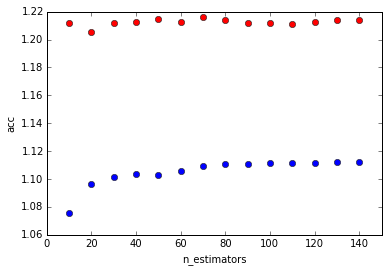

In [69]:
n_est = range(10, 150, 10)
%time results = get_results_baggind_rsm(n_est, 0.5, 0.5, verbose=True)
show_plot(n_est, results)

### Random Forest
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 1.14750326418
Count of estimators: 20, accuracy: 1.19079209072
Count of estimators: 30, accuracy: 1.202870609
Count of estimators: 40, accuracy: 1.20988840119
Count of estimators: 50, accuracy: 1.21082573286
Count of estimators: 60, accuracy: 1.2143448492
Count of estimators: 70, accuracy: 1.21500776834
Count of estimators: 80, accuracy: 1.21646848564
Count of estimators: 90, accuracy: 1.21776706812
Count of estimators: 100, accuracy: 1.2184335711
Count of estimators: 110, accuracy: 1.21834810699
Count of estimators: 120, accuracy: 1.21795573953
Count of estimators: 130, accuracy: 1.21776931967
Count of estimators: 140, accuracy: 1.21683105819
CPU times: user 1min 30s, sys: 2 s, total: 1min 32s
Wall time: 11.4 s


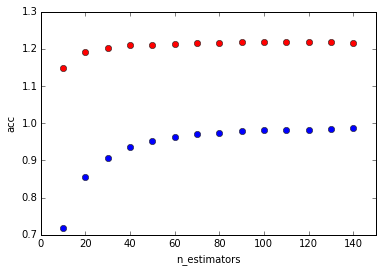

In [70]:
n_est = range(10, 150, 10)
%time results = get_results_rf(n_est)
show_plot(n_est, results)

### Extremely Randomized Trees Ensemble
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 1.11491067377
Count of estimators: 20, accuracy: 1.17244779479
Count of estimators: 30, accuracy: 1.19164393215
Count of estimators: 40, accuracy: 1.20184609665
Count of estimators: 50, accuracy: 1.20684291284
Count of estimators: 60, accuracy: 1.20979916421
Count of estimators: 70, accuracy: 1.21211058755
Count of estimators: 80, accuracy: 1.214271505
Count of estimators: 90, accuracy: 1.21482360132
Count of estimators: 100, accuracy: 1.21431803564
Count of estimators: 110, accuracy: 1.21476939337
Count of estimators: 120, accuracy: 1.21534473985
Count of estimators: 130, accuracy: 1.21537528033
Count of estimators: 140, accuracy: 1.21401967666
CPU times: user 2min 46s, sys: 2.88 s, total: 2min 49s
Wall time: 17 s


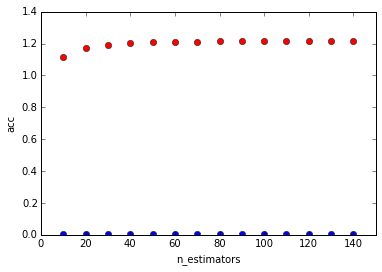

In [74]:
n_est = range(10, 150, 10)
%time results = get_results_erte(n_est)
show_plot(n_est, results)

## Gradient Boosted Decision Trees
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 1.22977470358
Count of estimators: 20, accuracy: 1.22639236183
Count of estimators: 30, accuracy: 1.22541568924
Count of estimators: 40, accuracy: 1.22768741816
Count of estimators: 50, accuracy: 1.22557414292
Count of estimators: 60, accuracy: 1.22574481035
Count of estimators: 70, accuracy: 1.22415032792
Count of estimators: 80, accuracy: 1.22401751986
Count of estimators: 90, accuracy: 1.22416706013
Count of estimators: 100, accuracy: 1.22184289628
Count of estimators: 110, accuracy: 1.2239811729
Count of estimators: 120, accuracy: 1.2237929322
Count of estimators: 130, accuracy: 1.22398520643
Count of estimators: 140, accuracy: 1.22351940855
CPU times: user 23.7 s, sys: 0 ns, total: 23.7 s
Wall time: 23.7 s


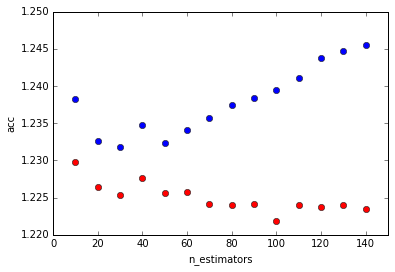

In [72]:
n_est = range(10, 150, 10)
%time results = get_results_gbdt(n_est)
show_plot(n_est, results)

### Вывод
Переобучаются ExtraDT, остальные методы показывают результаты на одном уровне (в пределах погрешности).

Для RF и Baggin+RSM оптимальные значения кол-ва близко к 20.

Для GBDT оптимальное количество алгоритмов находится в районе 50.

**Вопрос: Дайте интепретацию полученным результатам в вашем случае.**

Bagging и Boosting дают примерно одинаковые результаты: нужно работать как над уменьшением смещения, так и разброса.
Видимо, ...

Count of estimators: 1, accuracy: 0.851155367578
Count of estimators: 2, accuracy: 0.915688646412
Count of estimators: 3, accuracy: 0.960120807826
Count of estimators: 4, accuracy: 1.00806942614
Count of estimators: 5, accuracy: 1.03380852823
Count of estimators: 6, accuracy: 1.05782041493
Count of estimators: 7, accuracy: 1.07463014338
Count of estimators: 8, accuracy: 1.08944564217
Count of estimators: 9, accuracy: 1.10442768912
CPU times: user 6.23 s, sys: 201 ms, total: 6.43 s
Wall time: 4.22 s


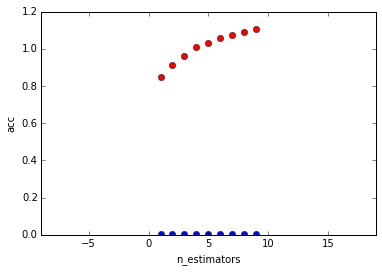

In [75]:
n_est = range(1, 10, 1)
%time results = get_results_erte(n_est)
show_plot(n_est, results)

Count of estimators: 1, accuracy: 0.856017556133
Count of estimators: 2, accuracy: 0.933179602437
Count of estimators: 3, accuracy: 0.99419697981
Count of estimators: 4, accuracy: 1.04059482184
Count of estimators: 5, accuracy: 1.06661817429
Count of estimators: 6, accuracy: 1.0910662704
Count of estimators: 7, accuracy: 1.10763600943
Count of estimators: 8, accuracy: 1.11995128435
Count of estimators: 9, accuracy: 1.13637274334
Count of estimators: 10, accuracy: 1.14750326418
CPU times: user 4.36 s, sys: 102 ms, total: 4.46 s
Wall time: 3.82 s


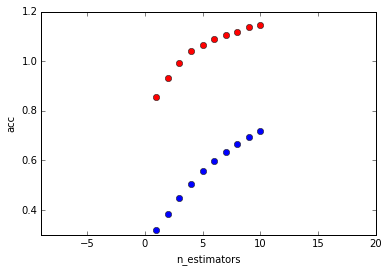

In [77]:
n_est = range(1, 11, 1)
%time results = get_results_rf(n_est)
show_plot(n_est, results)

Count of estimators: 150, accuracy: 1.22275785335
Count of estimators: 160, accuracy: 1.22234185377
Count of estimators: 170, accuracy: 1.2225610307
Count of estimators: 180, accuracy: 1.22199585302
Count of estimators: 190, accuracy: 1.22161030435
Count of estimators: 200, accuracy: 1.224125918
Count of estimators: 210, accuracy: 1.22417442024
Count of estimators: 220, accuracy: 1.22503394281
Count of estimators: 230, accuracy: 1.22554497867
Count of estimators: 240, accuracy: 1.22599263572
CPU times: user 48.5 s, sys: 0 ns, total: 48.5 s
Wall time: 48.5 s


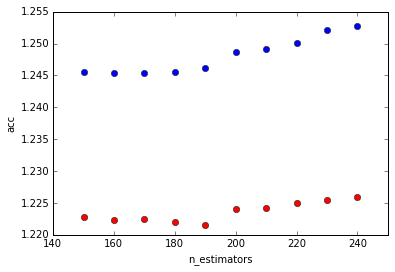

In [79]:
n_est = range(150, 250, 10)
%time results = get_results_gbdt(n_est)
show_plot(n_est, results)

Для модифицированных данных лучше всего работает ExtraDT и RF

In [80]:
#Неизмененные данные:
trainX, testX, trainY, testY = split_train_test(df = test_data, test_size=0.1,  y_column_name='DEMAND')

Count of estimators: 1, accuracy: 0.861795824368
Count of estimators: 2, accuracy: 0.942107157544
Count of estimators: 3, accuracy: 1.00362923835
Count of estimators: 4, accuracy: 1.04860641787
Count of estimators: 5, accuracy: 1.07706905619
Count of estimators: 6, accuracy: 1.0998258603
Count of estimators: 7, accuracy: 1.10879472885
Count of estimators: 8, accuracy: 1.1231793936
Count of estimators: 9, accuracy: 1.13575840538
CPU times: user 6.56 s, sys: 201 ms, total: 6.77 s
Wall time: 4.22 s


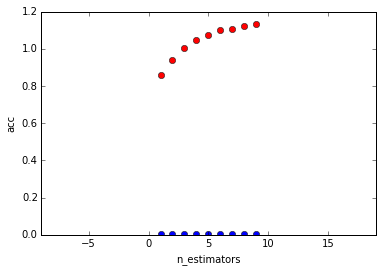

In [81]:
n_est = range(1, 10, 1)
%time results = get_results_erte(n_est)
show_plot(n_est, results)

(работает хуже)

## Использование категориальных признаков (1 балл)
* Проведите аналогичный экспермент при наличии категориальных признаков

### Обучение и Контроль

In [93]:
cat_data.head()

,DEMAND,LOCATION_ID,MODEL_BRAND,MODEL_COST_AVG,MODEL_COUNT_SALES_DAYS,MODEL_DIAG,MODEL_DIAG_TYPE,MODEL_HEIGHT,MODEL_ID,MODEL_MEAN_SALES,...,STORE_DIAG_SPECTR,STORE_FORMAT,STORE_OPEN_DTTM,STORE_REGION,STORE_RES_ABC,STORE_RES_SPECTR,STORE_TYPE_A,STORE_TYPE_B,STORE_TYPE_C,STORE_TYPE_SPECTR
ID,,,,,,,,,,,,,,,,,,,,,
0,0.10536,1835543262,ark,5179.7500,NaN,5.5,big,720,1682,NaN,...,0.78,новый формат,19MAY15:00:00:00,северо-запад,B,0.67,0.75,0.25,0,3.06
1,0.00010,1972241965,samsung,22015.3300,NaN,5.2,big,1920,34706,NaN,...,0.65,новый формат,20JAN16:00:00:00,северо-запад,C,0.48,0.00,1.00,0,2.51
2,0.00010,2027986985,samsung,15592.5900,NaN,5.0,big,1280,2753,NaN,...,0.67,новый формат,27APR16:00:00:00,дальний восток,A,0.64,1.00,0.00,0,2.72
3,0.00010,28432,alcatel,540.9533,29,1.8,small,128,1593,7.533,...,0.60,стандарт,21OCT09:00:00:00,северо-запад,B,0.65,0.50,0.25,0,2.04
4,0.00010,28547,мтс,444.7300,30,4.0,medium,480,80644,16.830,...,0.71,стандарт,20MAY09:00:00:00,северо-запад,A,0.83,0.75,0.25,0,2.37


In [94]:
#Работаем с cat_data:
cat_data['STORE_TYPE_A'][cat_data['STORE_TYPE_A']<0.5]=0
cat_data['STORE_TYPE_B'][cat_data['STORE_TYPE_B']<0.5]=0
cat_data['STORE_TYPE_C'][cat_data['STORE_TYPE_C']<0.5]=0
cat_data['STORE_TYPE_A'][cat_data['STORE_TYPE_A']>0.5]=1
cat_data['STORE_TYPE_B'][cat_data['STORE_TYPE_B']>0.5]=1
cat_data['STORE_TYPE_C'][cat_data['STORE_TYPE_C']>0.5]=1

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/root/miniconda/envs/rep_py2/lib/python2.7/

In [96]:
cat_data[features] = cat_data[features].fillna(0)

# Здесь добавьте код по удалению числовых признаков
cat_data.drop(['STORE_RES_SPECTR'], axis = 1, inplace=True)
cat_data.columns

Index([u'DEMAND', u'LOCATION_ID', u'MODEL_BRAND', u'MODEL_COST_AVG',
       u'MODEL_COUNT_SALES_DAYS', u'MODEL_DIAG', u'MODEL_DIAG_TYPE',
       u'MODEL_HEIGHT', u'MODEL_ID', u'MODEL_MEAN_SALES', u'MODEL_NAME',
       u'MODEL_OS', u'MODEL_RES_TYPE', u'MODEL_TYPE', u'MODEL_WIDTH',
       u'STORE_ASSORTMENT', u'STORE_BRAND_ABC', u'STORE_BRAND_SPECTR',
       u'STORE_BUILDING_TYPE', u'STORE_CITY', u'STORE_CLUSTER',
       u'STORE_DIAG_ABC', u'STORE_DIAG_SPECTR', u'STORE_FORMAT',
       u'STORE_OPEN_DTTM', u'STORE_REGION', u'STORE_RES_ABC', u'STORE_TYPE_A',
       u'STORE_TYPE_B', u'STORE_TYPE_C', u'STORE_TYPE_SPECTR'],
      dtype='object')

In [97]:
# Для обучения используются полезные категориальные признаки
bin_data = get_binarized_data(cat_data, Categorical_columns_use)
print(bin_data.shape)

(40000, 841)


##### Исключаем лишние произнаки, заменяем NaN

In [ ]:
# Удаляем лишние категоримальные признаки
bin_data.drop(Cathegorical_columns[лишние категориальные признаки], axis = 1, inplace=True)

In [ ]:
# Удаляем лишние числвые признаки признаки
bin_data = bin_data.drop([лишние числовые признаки], axis = 1, inplace = True)

In [98]:
# Заменяем NaN
bin_data.fillna(0, inplace = True)

In [99]:
# Делим выборку на обучение и контроль
trainX, testX, trainY, testY = split_train_test(df = bin_data, test_size=0.1,  y_column_name='DEMAND')

### Bagging and RSM
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 1.15699968877
Count of estimators: 20, accuracy: 1.18203437582
Count of estimators: 30, accuracy: 1.18645092593
Count of estimators: 40, accuracy: 1.1896945103
Count of estimators: 50, accuracy: 1.19407763041
Count of estimators: 60, accuracy: 1.19573702042
Count of estimators: 70, accuracy: 1.19544348245
Count of estimators: 80, accuracy: 1.19694194811
Count of estimators: 90, accuracy: 1.19571517851
Count of estimators: 100, accuracy: 1.19695077391
Count of estimators: 110, accuracy: 1.19581644326
Count of estimators: 120, accuracy: 1.19506062393
Count of estimators: 130, accuracy: 1.19445445735
Count of estimators: 140, accuracy: 1.19348136202
Wall time: 13min 17s


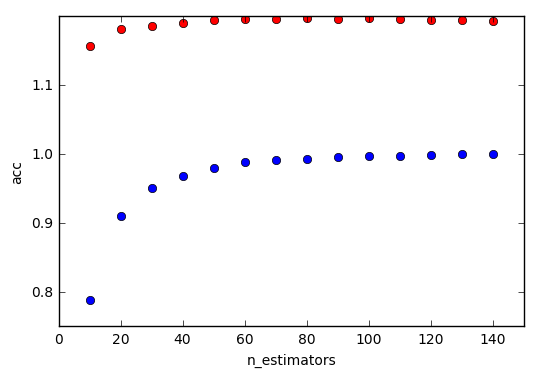

In [293]:
n_est = range(10, 150, 10)
%time results = get_results_baggind_rsm(n_est, 0.9, 0.9, verbose=True)
show_plot(n_est, results)

### Random Forest
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 1, accuracy: 0.872234626953
Count of estimators: 2, accuracy: 0.968396960471
Count of estimators: 3, accuracy: 1.02213080766
Count of estimators: 4, accuracy: 1.05746359886
Count of estimators: 5, accuracy: 1.0861921747
Count of estimators: 6, accuracy: 1.11614886913
Count of estimators: 7, accuracy: 1.12930357391
Count of estimators: 8, accuracy: 1.1401975885
Count of estimators: 9, accuracy: 1.15095205928
CPU times: user 18.8 s, sys: 701 ms, total: 19.5 s
Wall time: 8.32 s


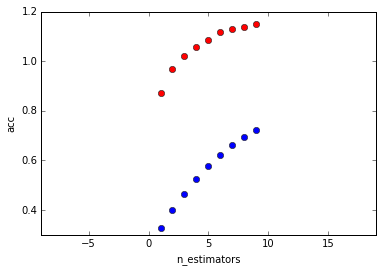

In [101]:
n_est = range(1, 10, 1)
%time results = get_results_rf(n_est)
show_plot(n_est, results)

### Extremely Randomized Trees Ensemble
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 1, accuracy: 0.731626981846
Count of estimators: 2, accuracy: 0.766762963723
Count of estimators: 3, accuracy: 0.81045274278
Count of estimators: 4, accuracy: 0.838075943683
Count of estimators: 5, accuracy: 0.865951900858
Count of estimators: 6, accuracy: 0.882819961105
Count of estimators: 7, accuracy: 0.905145102766
Count of estimators: 8, accuracy: 0.916829904725
Count of estimators: 9, accuracy: 0.927146138637
CPU times: user 15min 4s, sys: 737 ms, total: 15min 4s
Wall time: 3min 20s


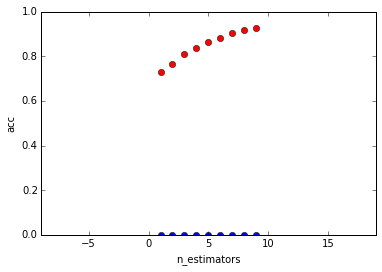

In [102]:
n_est = range(1, 10, 1)
%time results = get_results_erte(n_est)
show_plot(n_est, results)

### Gradient Boosted Decision Trees
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 1.23647479812
Count of estimators: 20, accuracy: 1.2319271105
Count of estimators: 30, accuracy: 1.22711722873
Count of estimators: 40, accuracy: 1.22327720049
Count of estimators: 50, accuracy: 1.22259612735
Count of estimators: 60, accuracy: 1.21965220455
Count of estimators: 70, accuracy: 1.21675080389
Count of estimators: 80, accuracy: 1.21466139927
Count of estimators: 90, accuracy: 1.21333242439
Count of estimators: 100, accuracy: 1.21093695731
Count of estimators: 110, accuracy: 1.21001948269
Count of estimators: 120, accuracy: 1.21009679306
Count of estimators: 130, accuracy: 1.20949188327
Count of estimators: 140, accuracy: 1.20843396288
CPU times: user 43min 11s, sys: 2.51 s, total: 43min 13s
Wall time: 43min 14s


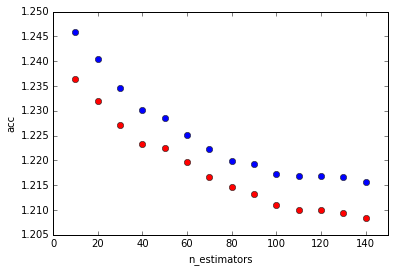

In [137]:
n_est = range(10, 150, 10)
%time results = get_results_gbdt(n_est)
show_plot(n_est, results)

Посмотрим, улучшится ли результат при следующем:

In [156]:
#Добавим LOCATION_ID и MODEL_ID к категориальным признакам
Categorical_columns_use += cat_data[['LOCATION_ID', 'MODEL_ID']].columns

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: using '+' to provide set union with Indexes is deprecated, use '|' or .union()
  from ipykernel import kernelapp as app


In [157]:
bin_data = get_binarized_data(cat_data, Categorical_columns_use)
bin_data.fillna(0, inplace = True)
trainX, testX, trainY, testY = split_train_test(df = bin_data, test_size=0.1,  y_column_name='DEMAND')

In [158]:
n_est = range(1, 3, 1)
%time results = get_results_erte(n_est)

Count of estimators: 1, accuracy: 0.712672658054
Count of estimators: 2, accuracy: 0.753568140196
CPU times: user 2min 47s, sys: 291 ms, total: 2min 48s
Wall time: 1min 52s


### Вывод

Лучше всего работает Extremely Randomized Trees Ensemble с модификацией типов магазина и убиранием некоторых признаков

## Другие модели и генерация дополнительных признаков (2 балла)

* На основании сделанных выводов, предложите другой вариант алгоритма ML, который должен показать лучший результат
* Направляния:
    -- использовать принципиально другое семейство алгоритмов (NN, GB+kNN, LinearRegression, композиция Baggin и GBDT)
    -- исключить бесполезные фичи из обучающей выборки (полезность фич проанализировать с помощью RF);
    -- исключить фичи, в которых есть NaN; сделать восстановление NaN более интеллектуально;
    -- преобразовать катеориальные признаки так, чтобы получились числовые.

## Отправка результатов в контест на Kaggle (оценивается по результатам в Leaderboard)

In [143]:
test = pd.read_csv('./test.csv', sep=';',decimal= '.', index_col='ID')

In [144]:
test.drop(['STORE_PRICE_TYPE'], axis = 1, inplace=True)
test['STORE_TYPE_A'][test['STORE_TYPE_A']<0.5]=0
test['STORE_TYPE_B'][test['STORE_TYPE_B']<0.5]=0
test['STORE_TYPE_C'][test['STORE_TYPE_C']<0.5]=0
test['STORE_TYPE_A'][test['STORE_TYPE_A']>0.5]=1
test['STORE_TYPE_B'][test['STORE_TYPE_B']>0.5]=1
test['STORE_TYPE_C'][test['STORE_TYPE_C']>0.5]=1

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/root/miniconda/envs/rep_py2/lib/python2.7/

In [145]:
test[features] = test[features].fillna(0)
test.drop(['STORE_RES_SPECTR'], axis = 1, inplace=True)

In [146]:
# Предобработка тестовой выборки (добавляем\удаляем признаки, предобработка NaN и пр.)
test_data = get_binarized_data(test, Categorical_columns_use)

In [147]:
# Все отсутствующие в тестовой выборке столбцы полагаем 0
add_columns = bin_data.columns[1:].difference(test_data.columns)
test_data = pd.merge(test_data, bin_data.ix[test_data.index][add_columns], how='inner', left_index=True, right_index=True)
test_data[add_columns]=0

# Оставляем только столбцы обучающей выборки (целевая переменная в обучающей выборке отсутствует)
test_data = test_data[bin_data.columns[1:]]

#test_data = test_data.fillna(0, inplace=True)

In [148]:
# Обучающая выборка
trainX, _, trainY, _ = split_train_test(df = bin_data, test_size=0,  y_column_name='DEMAND')

In [149]:
# Обучаем финальный алгоритм
final_regressor = ExtraTreesRegressor(n_estimators=1, n_jobs=-1, random_state=12, verbose=0)
final_regressor.fit(trainX, trainY)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=1, n_jobs=-1, oob_score=False, random_state=12,
          verbose=0, warm_start=False)

In [150]:
# Предсказание интенсивности
test_predict = final_regressor.predict(np.asarray(test_data))

In [151]:
# Сохраняем в csv-файл
test['DEMAND'] = test_predict
test[['DEMAND']].to_csv('./submission_best.csv', sep = ',', index = True)